<a href="https://colab.research.google.com/github/zarrinan/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [83]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [84]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=18.426713759320656, pvalue=9.969880374039127e-05)


In [85]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.
from scipy import stats
b1 = stats.binom(n=100, p=0.6)

In [87]:
b1.mean()

60.0

In [88]:
b1.median()

60.0

In [89]:
import random
random.seed(100)  # Reproducibility! Next line should give 2386
random.randint(0, 10000)

2386

In [90]:
chi2 = stats.chi2(500)
chi2.mean()

500.0

In [91]:
chi2.median()

499.3334915888738

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval ]{:.2}, {:.2}[".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [93]:
x = 2
print('x is: {}'.format(x))

x is: 2


In [94]:
coinflips = np.random.binomial(n=1, p=0.5, size=100)
print(coinflips)

[0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1
 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0
 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0]


In [95]:
import pandas as pd
df = pd.DataFrame(coinflips)
df.describe()

,0
count,100.000000
mean,0.510000
std,0.502418
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [96]:
coinflip_interval = confidence_interval(coinflips, confidence=0.95)
coinflip_interval

(0.51, 0.4103092906280824, 0.6096907093719176)

In [97]:
report_confidence_interval(coinflip_interval)

'our mean lies in the interval ]0.41, 0.61['

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.

In [98]:
# Getting started with drug data
# http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip

--2018-12-05 01:31:39--  http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/zip]
Saving to: ‘drugsCom_raw.zip.1’

drugsCom_raw.zip.1  100%[===================>]  41.00M  11.1MB/s    in 4.8s    

2018-12-05 01:31:44 (8.47 MB/s) - ‘drugsCom_raw.zip.1’ saved [42989872/42989872]



In [0]:
!unzip drugsCom_raw.zip

In [100]:
!head drugsComTrain_raw.tsv

	drugName	condition	review	rating	date	usefulCount
206461	Valsartan	Left Ventricular Dysfunction	"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"""	9.0	May 20, 2012	27
95260	Guanfacine	ADHD	"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. 
We have tried many different medications and so far this is the most effective."""	8.0	April 27, 2010	192
92703	Lyb

In [101]:
df = pd.read_table('drugsComTrain_raw.tsv', delimiter='\t')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
  return (mean, mean - interval, mean+ interval)
  

In [0]:
def print_report(confidence_interval, data=df.usefulCount):
  a = confidence_interval(data)
  s = 'the mean is {:.2}, and the confidence interval lies within {:.2} and {:.2}'.format(a[0], a[1], a[2])
  return s

In [110]:
#calculate the drug rating for the confidence interval 0.95
print_report(confidence_interval, data=df.rating)

'the mean is 7.0, and the confidence interval lies within 7.0 and 7.0'

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_report(confidence_interval, data=df.rating):
  a = confidence_interval(data)
  return(
  plt.plot(a[0], 'h'),
  plt.plot(a[1], 'h'),
  plt.plot(a[2], 'h'),
  )


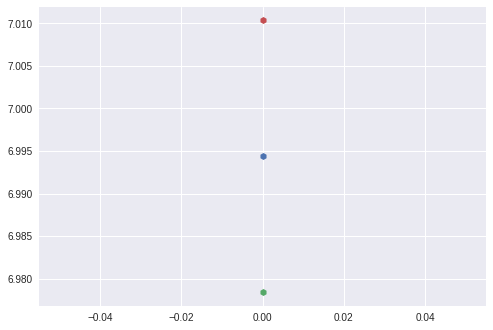

In [135]:
plot_report(confidence_interval, data=df.rating);

In [0]:
df.describe()

In [0]:
df.head()

In [0]:
df.rename(index=str, columns={'Unnamed: 0':'quantity'}, inplace=True)

In [0]:
df.head(5)

In [0]:
# filter a dataframe by the counts of values in a column and 
#calculate ratings mean and and confidence intervals

def filter_data(data, column = 'drugName', filter=100):
  
  #filter an initial dataframe by the counts of values in a column
  data_new = df.groupby(column).filter(lambda x: len(x) > filter)
  
  #make a list of unique values in the column
  list_new = data_new[column].unique()
  
  #declare a dictionary, where a value, and rating mean and confidence interval will be added
  mean_ci = {}
  
  #iterate through the list of unique values and for every value,
  #calculate ratings mean and and confidence interval
  for i in list_new:
    df_new = data_new[data_new[column] == i]
    a = confidence_interval(df_new.rating)
    mean_ci[i] = [a[0], a[1], a[2]]  
  return mean_ci 
 

In [0]:
# Visualize the resulting data in a box plot
def plot_data(dictionary):
  labels, data = [*zip(*dictionary.items())]  # 'transpose' dict items to parallel key, value lists
  plt.figure(figsize=(20,10))
  plt.boxplot(data, whis=0, meanline=True, )
  plt.xticks(range(1, len(labels) + 1), labels)
  plt.show()


In [0]:
#calculate the mean and confidence intervals for drugs with more that 100 reviews
#and save the result in the 'drug_ratings_mean_ci' dictionary
drug_ratings_mean_ci = filter_data(df, 'drugName', 100)

In [0]:
drug_rating_data = filter_data(df, 'drugName', 1000)

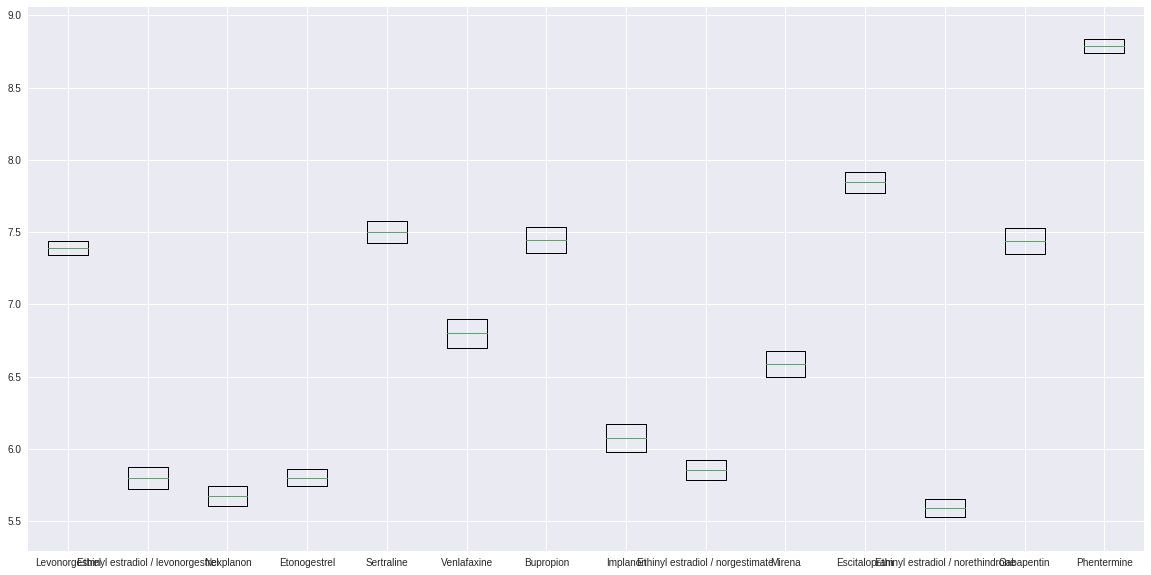

In [187]:
plot_data(drug_rating_data)

In [0]:
#visualize data in a violin plot
def violin_plot(dictionary):
  labels, data = [*zip(*dictionary.items())]  # 'transpose' dict items to parallel key, value lists
  plt.figure(figsize=(20,10))
  plt.violinplot(data)
  plt.xticks(range(1, len(labels) + 1), labels)
  plt.show()

  

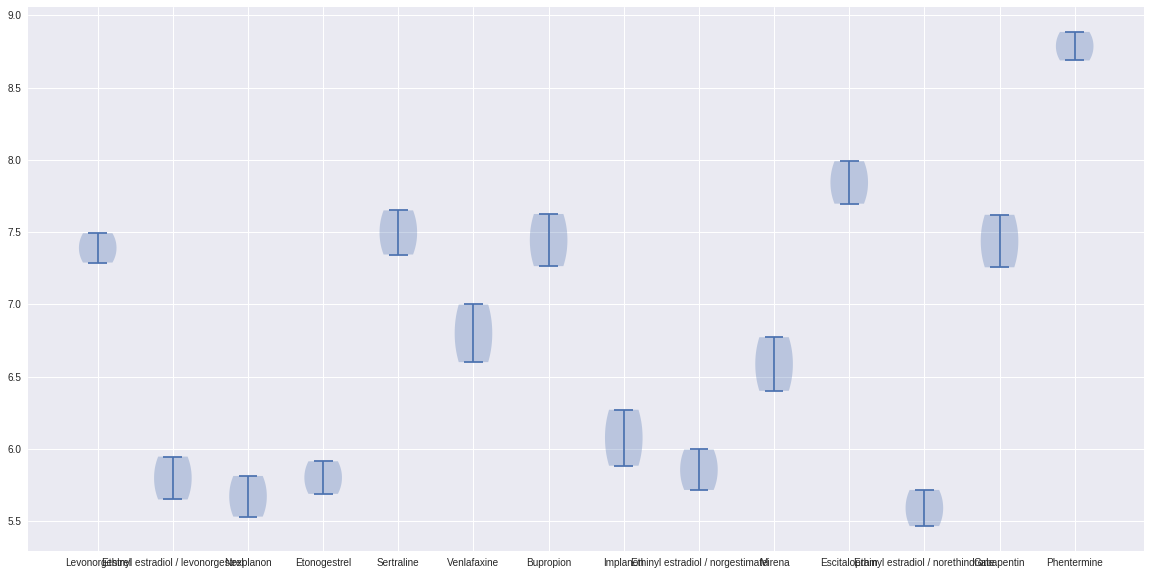

In [192]:
violin_plot(drug_rating_data)

In [0]:
condition_data = filter_data(df, 'condition', 2000)

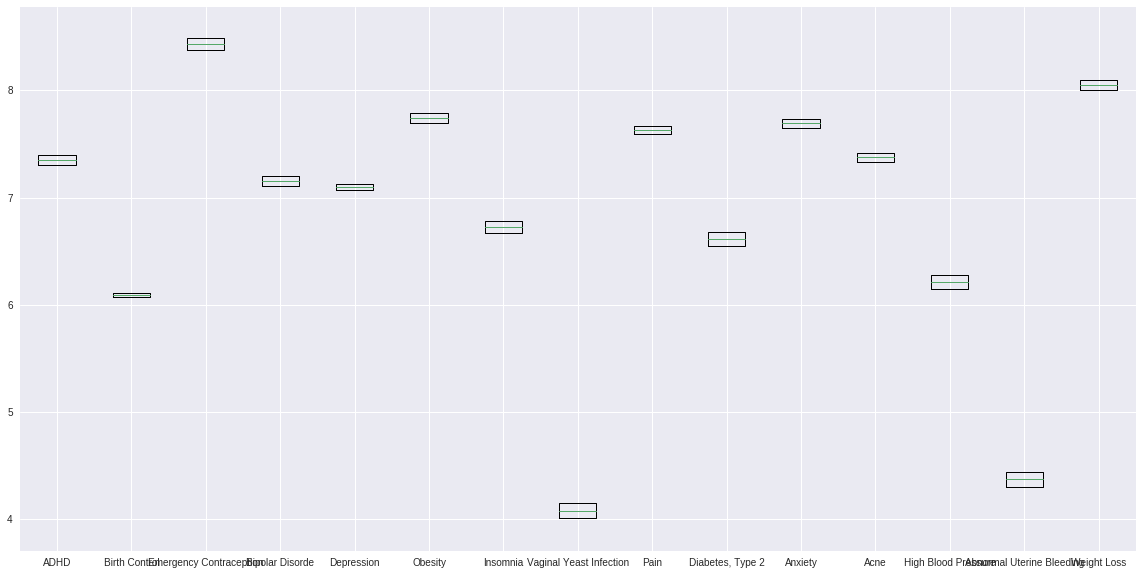

In [198]:
plot_data(condition_data)